# MARATONA BEHIND THE CODE 2020

## DESAFIO 2: PARTE 1
- Autor: Rodrigo Lima

# Parte 1. Importando os pacotes

In [28]:
import numpy as np
import pandas as pd

import matplotlib as m
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import imblearn
from imblearn.over_sampling import SMOTE

import sklearn
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

# Imports para formatação dos gráficos
plt.style.use('fivethirtyeight')
m.rcParams['axes.labelsize'] = 14
m.rcParams['xtick.labelsize'] = 12
m.rcParams['ytick.labelsize'] = 12
m.rcParams['text.color'] = 'k'
from matplotlib.pylab import rcParams 
rcParams['figure.figsize'] = 14,6

# Parte 2. Carregando os Dados

In [2]:
# Carregando os dados
dados = pd.read_csv('../data/dataset_desafio_2.csv')

# Parte 3. Feature Engineering

In [3]:
# Removendo colunas unicas
dados.drop(['MATRICULA', 'NOME', 'H_AULA_PRES'], axis = 1, inplace = True)

# Preencher missing com zero
dados.fillna(0, inplace=True)

# Categorizar a coluna target
dados['PERFIL'] = dados['PERFIL'].astype("category").cat.codes

# Criar duas colunas: soma e media das notas
cols_notas = ['NOTA_DE','NOTA_EM','NOTA_MF','NOTA_GO']
dados['SOMA_NOTAS']  = dados[cols_notas].sum(axis=1)
dados['MEDIA_NOTAS'] = dados[cols_notas].mean(axis=1)

# Parte 4. Machine Learning
> Utilizarei o algoritmo Random Forest

### Split dos dados em Treino e Teste

In [7]:
# Criando a instância:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=337)

# Criando os datasets de treino e teste utilizando amostragem estratificada:
for train_index, test_index in split.split(dados, dados['PERFIL']):
    strat_train_set = dados.loc[train_index]
    strat_test_set = dados.loc[test_index]
    
# Reset no índice do dataset de treino:
strat_train_set.reset_index(drop=True, inplace=True)

# Reset no índice do dataset de teste:
strat_test_set.reset_index(drop=True, inplace=True)

# Mostrando o resultado (número de observações em cada dataset):
print(len(strat_train_set), "train +", len(strat_test_set), "test", "=", (len(strat_train_set) + len(strat_test_set)))

# Definição das colunas que serão features (variáveis preditoras):
features = list(dados.columns) # cria uma lista com todas as variáveis do dataset.
features.remove('PERFIL') # remove a variável target.

# Definição da variável-alvo:
target = ['PERFIL']

# Criação dos dados de treino:
X_train = strat_train_set[features]
y_train = strat_train_set[target]

# Criação dos dados de teste:
X_test = strat_test_set[features]
y_test = strat_test_set[target]

14000 train + 6000 test = 20000


### Aplicando balanceamento nos dados de treino

In [10]:
# Criamos o objeto SMOTE
sm = SMOTE(random_state = 337)

# Treinamos o balanceador SMOTE
X_bal, Y_bal = sm.fit_sample(X_train, y_train)

# Aplicando a mesma escala nos dados
X_bal = MinMaxScaler().fit_transform(X_bal)

# Padronizando os dados (0 para a média, 1 para o desvio padrão)
X_bal = StandardScaler().fit_transform(X_bal)


### Realizando o treinamento do modelo
> Vou utilizar a técnica de Cross-Validation

In [17]:
# Definindo os valores para o número de folds
num_folds = 15
seed = 337

# Preparando a lista de modelos
model_rf = RandomForestClassifier()

kfold = KFold(n_splits = num_folds, random_state = seed)
cv_results = cross_val_score(model_rf, X_bal, Y_bal, cv = kfold, scoring = 'accuracy')

msg = "RF: %f (%f)" % (cv_results.mean(), cv_results.std())
print(msg)

RF: 0.868917 (0.047991)


### Realizando a validação do modelo com dados de teste

In [21]:
# Aplicando a mesma escala nos dados
X_test_bal = MinMaxScaler().fit_transform(X_test)

# Padronizando os dados (0 para a média, 1 para o desvio padrão)
X_test_bal = StandardScaler().fit_transform(X_test_bal)

# Realizando as previsões
rf_y_pred = cross_val_predict(model_rf, X_test_bal, y_test, cv=num_folds)

# Relatório de Classificação
print(classification_report(y_test, rf_y_pred))

              precision    recall  f1-score   support

           0       0.88      0.76      0.81      2100
           1       0.81      0.90      0.85      2469
           2       0.66      0.64      0.65       201
           3       0.77      0.94      0.85       959
           4       0.31      0.09      0.14       271

    accuracy                           0.81      6000
   macro avg       0.69      0.66      0.66      6000
weighted avg       0.80      0.81      0.80      6000



### Visualizando o desempenho do modelo

Text(0.5, 1.0, 'Confusion Matrix')

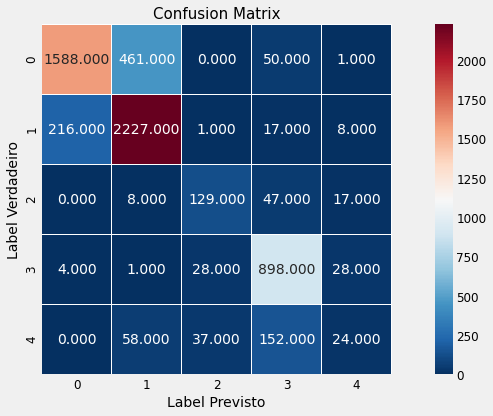

In [29]:
# Matriz de Confusão
sns.heatmap(confusion_matrix(y_test, rf_y_pred), 
            annot = True, 
            fmt = ".3f", 
            linewidths = .5, 
            square = True, 
            cmap = 'RdBu_r')

# Labels e Títulos
plt.ylabel('Label Verdadeiro')
plt.xlabel('Label Previsto')
plt.title("Confusion Matrix", size = 15)